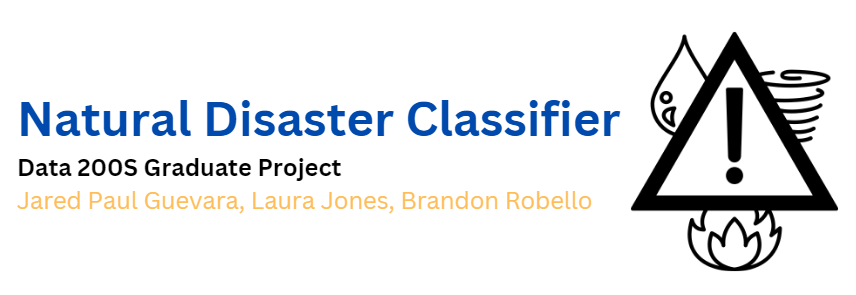


# Modeling - Task A: `socal-fire` vs. `midwest-flooding`


The model we'll be using to complete Task A and B are support vector machines (SVMs), specifically `sklearn`'s `LinearSVC` model, which is suited for both binary (Task A) and multi-class classification (Task B).


**Importing `LinearSVC` from `sklearn`:**


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
task_A_df = pd.read_csv('../data/task-data/task-A.csv')
assert(task_A_df.isna().any().all() == False)
task_A_df.head()

,image_matrix,disaster,label,height,width,aspect_ratio,total_pixels,avg_pixel_int,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var,area of red pixels at 150 threshold,area of green pixels at 150 threshold,area of blue pixels at 150 threshold
0,[[[ 50 72 48]\n [ 49 71 47]\n [ 49 71 ...,socal-fire,0,144,195,1.354167,28080,122.675415,4.963108,4.652137,0.048752,3.979585e-07,0.000144,0.235399,0.310043,0.300214
1,[[[ 66 84 80]\n [ 79 99 94]\n [103 127 1...,socal-fire,0,48,51,1.062500,2448,82.526416,5.270881,4.534314,0.046197,4.679938e-07,0.000121,0.010621,0.017157,0.075163
2,[[[ 74 107 95]\n [ 74 106 95]\n [ 70 100 ...,socal-fire,0,104,140,1.346154,14560,110.527908,4.821204,4.668475,0.043064,2.617666e-07,0.000152,0.098420,0.171429,0.151580
3,[[[100 114 111]\n [102 115 112]\n [105 117 1...,socal-fire,0,128,138,1.078125,17664,105.995131,4.830619,4.610054,0.044347,2.846567e-07,0.000125,0.067652,0.125170,0.125566
4,[[[ 67 100 90]\n [ 65 98 88]\n [ 60 92 ...,socal-fire,0,65,96,1.476923,6240,93.071047,5.323417,4.728526,0.037459,2.879416e-07,0.000151,0.027404,0.054487,0.114263


In [18]:
X = task_A_df.iloc[:, 3:]
y = task_A_df['disaster'].replace({'midwest-flooding' : 0,
                                 'socal-fire' : 1})
assert(len(X) == 8380+7004)
assert(len(y) == 8380+7004)

print(f'Top five rows of X:')
display(X.head())
print(X.shape)

Top five rows of X:


,height,width,aspect_ratio,total_pixels,avg_pixel_int,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var,area of red pixels at 150 threshold,area of green pixels at 150 threshold,area of blue pixels at 150 threshold
0,144,195,1.354167,28080,122.675415,4.963108,4.652137,0.048752,3.979585e-07,0.000144,0.235399,0.310043,0.300214
1,48,51,1.062500,2448,82.526416,5.270881,4.534314,0.046197,4.679938e-07,0.000121,0.010621,0.017157,0.075163
2,104,140,1.346154,14560,110.527908,4.821204,4.668475,0.043064,2.617666e-07,0.000152,0.098420,0.171429,0.151580
3,128,138,1.078125,17664,105.995131,4.830619,4.610054,0.044347,2.846567e-07,0.000125,0.067652,0.125170,0.125566
4,65,96,1.476923,6240,93.071047,5.323417,4.728526,0.037459,2.879416e-07,0.000151,0.027404,0.054487,0.114263


(15384, 13)


In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=[feature for feature in X.columns])

print(f'\nTop five rows of features after scaling:')
display(X_scaled.head())
print(X_scaled.shape)

# Instantiate PCA
pca = PCA()

# Fit the PCA onto the training data
pca_X = pca.fit_transform(X)

print(f'Explained variance ratio of principal components: \n{pca.explained_variance_ratio_}\nPrincipal component(s) with largest ratio: PC{pca.explained_variance_ratio_.argmax()+1}')
print(f'Absolute value of features of PC1: \n{abs(pca.components_[0])}\nFeature with the largest absolute value: {X.columns[pca.components_.argmax()]}')

X_scaled
svc = LinearSVC(dual= False, C=10, max_iter=1000)
svc.fit(X_scaled, y)
svc.score(X_scaled, y)

In [19]:
# LinearSVC Feature Selection (runtime: ~8sec)
def svc_feature_selection(features):
  feature_scores = []

  for combo in features:
    X_train, X_val, y_train, y_val = train_test_split(X[combo], y, test_size=0.2, random_state=42)
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
    feature_scores.append((combo, pipe.fit(X_train, y_train).score(X_train, y_train)))

  return feature_scores

feature_combinations = [['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']]

print(f'Best training score among feature combinations: {max(svc_feature_selection(feature_combinations))[1]:.3f}')

svc_best_params = max(svc_feature_selection(feature_combinations))[0]
print(f'Best parameters for LinearSVC: {svc_best_params}')

Best training score among feature combinations: 0.982
Best parameters for LinearSVC: ['lbp_var', 'lbp_mean', 'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']


In [20]:
# LinearSVC Grid Search (runtime: ~1min 20sec)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('svc', LinearSVC())])

param_grid = {'svc__C' : [0.01, 0.1, 1, 10, 100],
              'svc__max_iter' : [500, 1000, 2000, 3000],
              'svc__penalty' : ['l1', 'l2']}

best_X = X[svc_best_params]

grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(best_X, y)

print(f'Best score: {grid_search.best_score_:.3f}')
print(f'Best hyperparameters for LinearSVC model: {grid_search.best_params_}')

Best score: 0.982
Best hyperparameters for LinearSVC model: {'svc__C': 10, 'svc__max_iter': 1000, 'svc__penalty': 'l2'}


We'll have to tune all hyperparameters: C, max iterations, and penalty type.


In [21]:
optimal_pipe = Pipeline([('scaler', StandardScaler()),
                         ('svc', LinearSVC(C=10, max_iter=1000))]) # default penalty is 'l2'

X_train, X_val, y_train, y_val = train_test_split(best_X, y, test_size=0.2, random_state=42)
optimal_pipe.fit(X_train, y_train)
svc_train_preds = optimal_pipe.predict(X_train)
svc_train_score = optimal_pipe.score(X_train, y_train)
svc_val_preds = optimal_pipe.predict(X_val)
svc_val_score = optimal_pipe.score(X_val, y_val)
svc_cv_score = cross_val_score(optimal_pipe, best_X, y, cv=10)
print(f'Initial training score: {svc_train_score}')
print(f'Initial validation score: {svc_val_score}')
print(f'Average cross-validation score across 10 folds: {svc_cv_score.mean()}')

Initial training score: 0.9822865036158284
Initial validation score: 0.9805004874878128
Average cross-validation score across 10 folds: 0.9820589256699037


              precision    recall  f1-score   support

           0      0.984     0.973     0.979      1404
           1      0.978     0.987     0.982      1673

    accuracy                          0.981      3077
   macro avg      0.981     0.980     0.980      3077
weighted avg      0.981     0.981     0.980      3077



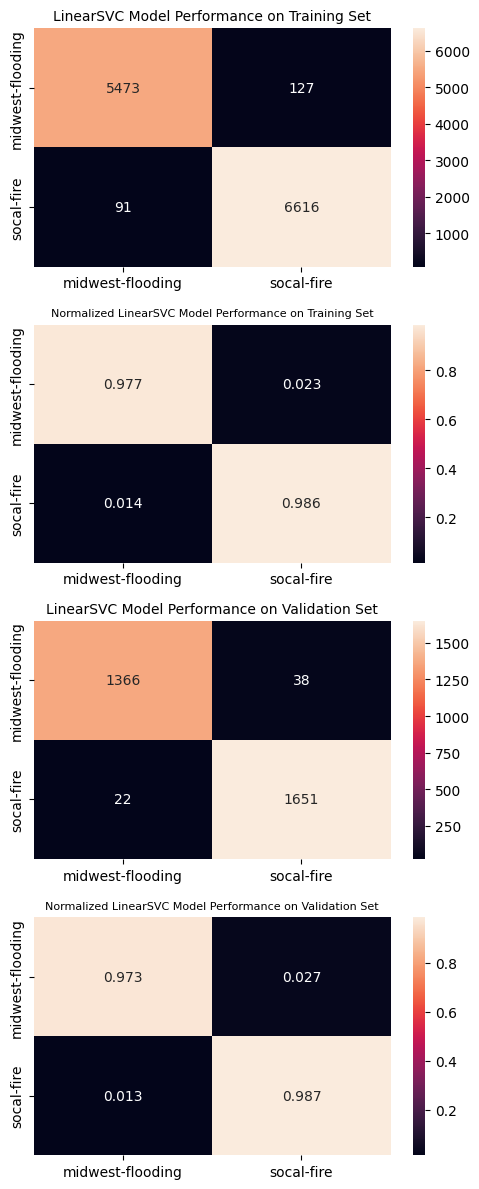

In [22]:
print(classification_report(y_val, svc_val_preds, digits=3))

plt.subplots(figsize=(5,12))

plt.subplot(4, 1, 1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, svc_train_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('LinearSVC Model Performance on Training Set', fontsize=10)

plt.subplot(4, 1, 2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, svc_train_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized LinearSVC Model Performance on Training Set', fontsize=8)

plt.subplot(4, 1, 3)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, svc_val_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('LinearSVC Model Performance on Validation Set', fontsize=10)

plt.subplot(4, 1, 4)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, svc_val_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized LinearSVC Model Performance on Validation Set', fontsize=8)

plt.tight_layout()
plt.show()

In [23]:
# RandomForestClassifier Feature Selection (runtime: ~45sec)
def rfc_feature_selection(features):
  feature_scores = []

  for combo in features:
    X_train, X_val, y_train, y_val = train_test_split(X[combo], y, test_size=0.2, random_state=42)
    pipe = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=42))])
    feature_scores.append((combo, pipe.fit(X_train, y_train).score(X_train, y_train)))

  return feature_scores

feature_combinations = [['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']]

print(f'Best training score among feature combinations: {max(rfc_feature_selection(feature_combinations))[1]:.3f}')

rfc_best_params = max(rfc_feature_selection(feature_combinations))[0]
print(f'Best parameters for RandomForestClassifier: {rfc_best_params}')

Best training score among feature combinations: 1.000
Best parameters for RandomForestClassifier: ['lbp_var', 'lbp_mean', 'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']


In [24]:
# RandomForestClassifier Grid Search (runtime: ~38m)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('rfc', RandomForestClassifier(random_state=42))])

param_grid = {'rfc__n_estimators' : [10, 100],
              'rfc__max_features' : ['sqrt', 'log2', 0.33],
              'rfc__max_depth' : [1, 2, 5, 10]}

best_X = X[rfc_best_params]

grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(best_X, y)

print(f'Best score: {grid_search.best_score_:.3f}')
print(f'Best hyperparameters for RandomForestClassifier model: {grid_search.best_params_}')

Best score: 0.985
Best hyperparameters for RandomForestClassifier model: {'rfc__max_depth': 10, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 10}


In [25]:
optimal_pipe = Pipeline([('scaler', StandardScaler()),
                         ('rfc', RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=10, random_state=42))])

X_train, X_val, y_train, y_val = train_test_split(best_X, y, test_size=0.2, random_state=42)
optimal_pipe.fit(X_train, y_train)
rfc_train_preds = optimal_pipe.predict(X_train)
rfc_train_score = optimal_pipe.score(X_train, y_train)
rfc_val_preds = optimal_pipe.predict(X_val)
rfc_val_score = optimal_pipe.score(X_val, y_val)
rfc_cv_score = cross_val_score(optimal_pipe, best_X, y, cv=10)
print(f'Initial training score: {rfc_train_score}')
print(f'Initial validation score: {rfc_val_score}')
print(f'Average cross-validation score across 10 folds: {rfc_cv_score.mean()}')

Initial training score: 0.994799707483546
Initial validation score: 0.9840753981150471
Average cross-validation score across 10 folds: 0.9851139129913113


              precision    recall  f1-score   support

           0      0.988     0.977     0.982      1404
           1      0.981     0.990     0.985      1673

    accuracy                          0.984      3077
   macro avg      0.984     0.984     0.984      3077
weighted avg      0.984     0.984     0.984      3077



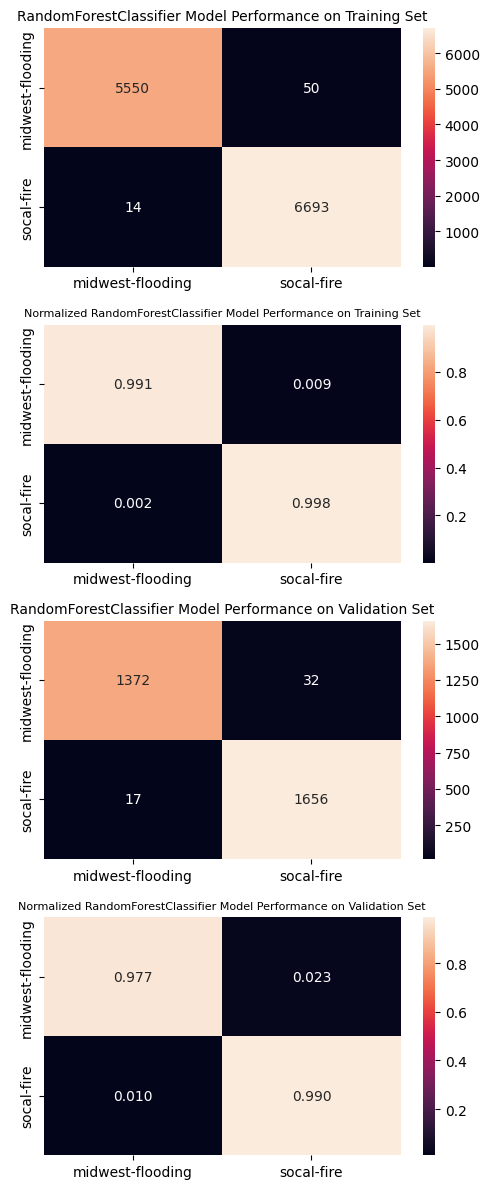

In [26]:
plt.subplots(figsize=(5,12))

print(classification_report(y_val, rfc_val_preds, digits=3))

plt.subplot(4, 1, 1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, rfc_train_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('RandomForestClassifier Model Performance on Training Set', fontsize=10)

plt.subplot(4, 1, 2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, rfc_train_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized RandomForestClassifier Model Performance on Training Set', fontsize=8)

plt.subplot(4, 1, 3)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, rfc_val_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('RandomForestClassifier Model Performance on Validation Set', fontsize=10)

plt.subplot(4, 1, 4)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, rfc_val_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized RandomForestClassifier Model Performance on Validation Set', fontsize=8)

plt.tight_layout()
plt.show()

In [27]:
print(f'LinearSVC vs. RandomForestClassifier Mean Cross-Validation Scores: {svc_cv_score.mean()} vs. {rfc_cv_score.mean()}')
print(f'LinearSVC vs. RandomForestClassifier Training Scores: {svc_train_score} vs. {rfc_train_score}')
print(f'LinearSVC vs. RandomForestClassifier Validation Scores: {svc_val_score} vs. {rfc_val_score}')

LinearSVC vs. RandomForestClassifier Mean Cross-Validation Scores: 0.9820589256699037 vs. 0.9851139129913113
LinearSVC vs. RandomForestClassifier Training Scores: 0.9822865036158284 vs. 0.994799707483546
LinearSVC vs. RandomForestClassifier Validation Scores: 0.9805004874878128 vs. 0.9840753981150471
